_Neural Data Analysis_

Lecturer: Jan Lause, Prof. Dr. Philipp Berens

Tutors: Jonas Beck, Rita González Márquez, Fabio Seel

Summer term 2024

Name: Gustav Schmidt, Julius Würzler, Noel Kury

# Coding Lab 5



In [17]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.optimize as opt
import scipy.io as io
import math

%load_ext jupyter_black

%load_ext watermark
%watermark --time --date --timezone --updated --python --iversions --watermark -p sklearn

%matplotlib inline
# plt.style.use("../matplotlib_style.txt")

The jupyter_black extension is already loaded. To reload it, use:
  %reload_ext jupyter_black
The watermark extension is already loaded. To reload it, use:
  %reload_ext watermark
Last updated: 2024-06-11 11:38:30Mitteleuropäische Sommerzeit

Python implementation: CPython
Python version       : 3.12.3
IPython version      : 8.24.0

sklearn: 1.4.2

sklearn   : 1.4.2
matplotlib: 3.9.0
scipy     : 1.13.0
numpy     : 1.26.4

Watermark: 2.4.3



## Task 1: Fit RF on simulated data

We will start  with toy data generated from an LNP model neuron to make sure everything works right. The model LNP neuron consists of one Gaussian linear filter, an exponential nonlinearity and a Poisson spike count generator. We look at it in discrete time with time bins of width $\delta t$. The model is:

$$
c_t \sim Poisson(r_t)\\
r_t = \exp(w^T s_t) \cdot \Delta t \cdot R
$$

Here, $c_t$ is the spike count in time window $t$ of length $\Delta t$, $s_t$ is the stimulus and $w$ is the receptive field of the neuron. The receptive field variable `w` is 15 × 15 pixels and normalized to $||w||=1$. A stimulus frame is a 15 × 15 pixel image, for which we use uncorrelated checkerboard noise. R can be used to bring the firing rate into the right regime (e.g. by setting $R=50$).      

For computational ease, we reformat the stimulus and the receptive field in a 225 by 1 array. The function ```sample_lnp``` can be used to generate data from this model. It returns a spike count vector `c` with samples from the model (dimensions: 1 by nT = $T/\Delta t$), a stimulus matrix `s` (dimensions: 225 × nT) and the mean firing rate `r` (dimensions: nT × 1). 

Here we assume that the receptive field influences the spike count instantaneously just as in the above equations. Implement a Maximum Likelihood approach to fit the receptive field. 

To this end simplify and implement the log-likelihood function $L(w)$ and its gradient $\frac{L(w)}{dw}$ with respect to $w$ (`negloglike_lnp`). The log-likelihood of the model is
$$L(w) = \log \prod_t \frac{r_t^{c_t}}{c_t!}\exp(-r_t).$$

Plot the true receptive field, a stimulus frame, the spike counts and the estimated receptive field. 

*Grading: 2 pts (calculations) + 3 pts (implementation)*


### Calculations
_You can add your calculations in_ $\LaTeX$ _here_.

\begin{align*}
L(\omega) &= \sum_t c_t \log(r_t) - \log(c_t!) - r_t \\
&= \sum_t c_t \log( \exp(\omega^Ts_t) \Delta t R) -\log(c_t!) - \exp(\omega^T s_t) \Delta t R \\
&= \sum_t c_t (\omega^T s_t + \log(\Delta t R)) - \log(c_t!) - \exp(\omega^T s_t) \Delta t R \\
\\
\frac{dL(\omega)}{d\omega} &= \sum_t c_t s_t - s_t \exp(\omega^T s_t) \Delta t R \\
&= \sum_t s_t (c_t - \exp(\omega^T s_t) \Delta t R)
\end{align*}

### Generate data

Text(0.5, 1.0, 'Gaussian RF')

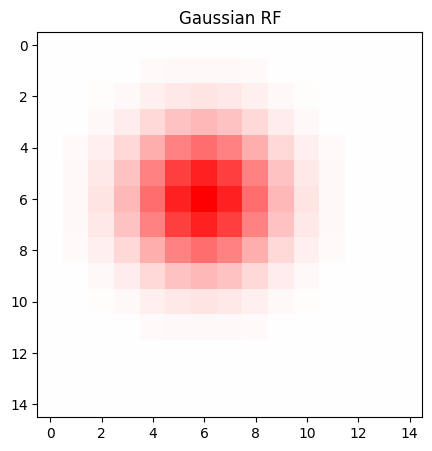

In [18]:
def gen_gauss_rf(D: int, width: float, center: tuple = (0, 0)) -> np.ndarray:
    """
    Generate a Gaussian receptive field.

    Args:
        D (int): Size of the receptive field (DxD).
        width (float): Width parameter of the Gaussian.
        center (tuple, optional): Center coordinates of the receptive field. Defaults to (0, 0).

    Returns:
        np.ndarray: Gaussian receptive field.
    """

    sz = (D - 1) / 2
    x, y = np.meshgrid(np.arange(-sz, sz + 1), np.arange(-sz, sz + 1))
    x = x + center[0]
    y = y + center[1]
    w = np.exp(-(x**2 / width + y**2 / width))
    w = w / np.sum(w.flatten())

    return w


w = gen_gauss_rf(15, 7, (1, 1))

vlim = np.max(np.abs(w))
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
ax.imshow(w, cmap="bwr", vmin=-vlim, vmax=vlim)
ax.set_title("Gaussian RF")

In [19]:
def sample_lnp(
    w: np.array, nT: int, dt: float, R: float, v: float, random_seed: int = 10
):
    """Generate samples from an instantaneous LNP model neuron with
    receptive field kernel w.

    Parameters
    ----------

    w: np.array, (Dx * Dy, )
        (flattened) receptive field kernel.

    nT: int
        number of time steps

    dt: float
        duration of a frame in s

    R: float
        rate parameter

    v: float
        variance of the flattened stimulus array

    random_seed: int
        seed for random number generator

    Returns
    -------

    c: np.array, (nT, )
        sampled spike counts in time bins

    r: np.array, (nT, )
        mean rate in time bins

    s: np.array, (Dx * Dy, nT)
        stimulus frames used

    Note
    ----

    See equations in task description above for a precise definition
    of the individual parameters.

    """

    rng = np.random.default_rng(random_seed)

    # insert your code here

    # ------------------------------------------------
    # Generate samples from an instantaneous LNP model
    # neuron with receptive field kernel w. (0.5 pts)
    # -----------------------------------------------

    s = rng.normal(0, np.sqrt(v), size=(len(w), nT))
    r = np.exp(w.T @ s) * dt * R
    c = np.random.poisson(r)
    return c.T, r.T, s

In [20]:
D = 15  # number of pixels
nT = 1000  # number of time bins
dt = 0.1  # bins of 100 ms
R = 50  # firing rate in Hz
v = 20  # stimulus variance

w = gen_gauss_rf(D, 7, (1, 1))
w = w.flatten()

c, r, s = sample_lnp(w, nT, dt, R, v)

Plot the stimulus for one frame, the cell's response over time and the spike count vs firing rate.

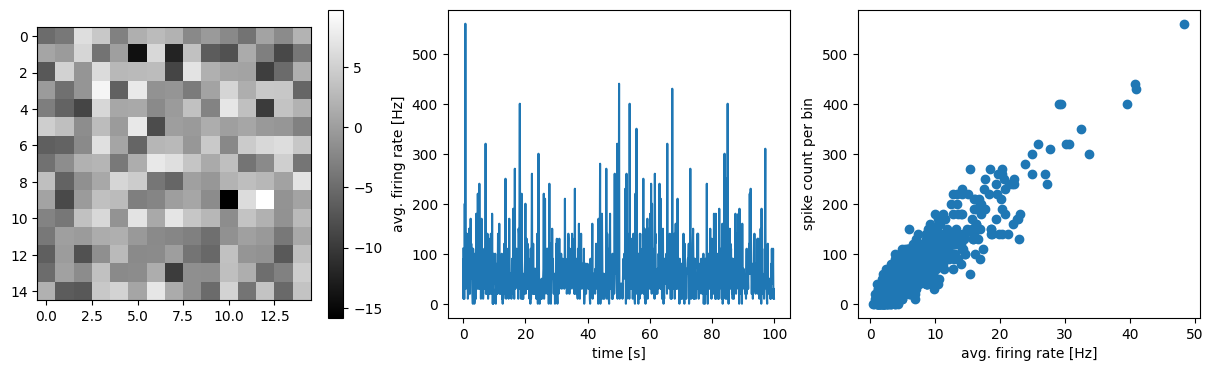

In [21]:
mosaic = mosaic = [["stim", "responses", "count/rate"]]

fig, ax = plt.subplot_mosaic(mosaic=mosaic, figsize=(15, 4))
# -----------------------------------------------------------------------------------------------------------
# Plot the stimulus for one frame, the cell's responses over time and spike count vs firing rate (0.5 points)
# -----------------------------------------------------------------------------------------------------------

# stimulus
s_image = s[:, 0].reshape(D, D)
s_ex = ax["stim"].imshow(s_image, cmap="gray")
fig.colorbar(s_ex, ax=ax["stim"])

# response over time
ax["responses"].plot(np.arange(0, len(c) * dt, dt), c * 10)
ax["responses"].set_ylabel("avg. firing rate [Hz]")
ax["responses"].set_xlabel("time [s]")

# spike count vs firing rate
ax["count/rate"].scatter(r, c * 10)
ax["count/rate"].set_xlabel("avg. firing rate [Hz]")
ax["count/rate"].set_ylabel("spike count per bin")

plt.show()

### Implementation 

Implement the negative log-likelihood of the LNP and its gradient with respect to the receptive field using the simplified equations you calculated earlier _(0.5 pts)_

In [22]:
def negloglike_lnp(
    w: np.array, c: np.array, s: np.array, dt: float = 0.1, R: float = 50
) -> float:
    """Implements the negative (!) log-likelihood of the LNP model

    Parameters
    ----------

    w: np.array, (Dx * Dy, )
      current receptive field

    c: np.array, (nT, )
      spike counts

    s: np.array, (Dx * Dy, nT)
      stimulus matrix


    Returns
    -------

    f: float
      function value of the negative log likelihood at w

    """
    # ------------------------------------------------
    # Implement the negative log-likelihood of the LNP
    # ------------------------------------------------

    # insert your code here

    r = np.exp(w.T @ s) * dt * R
    c_factorial = np.array([math.factorial(int(x)) for x in c]).astype(float)
    f = -np.sum(c * np.log(r) - np.log(c_factorial) - r)

    return f


def deriv_negloglike_lnp(
    w: np.array, c: np.array, s: np.array, dt: float = 0.1, R: float = 50
) -> np.array:
    """Implements the gradient of the negative log-likelihood of the LNP model

    Parameters
    ----------

    see negloglike_lnp

    Returns
    -------

    df: np.array, (Dx * Dy, )
      gradient of the negative log likelihood with respect to w

    """

    # --------------------------------------------------------------
    # Implement the gradient with respect to the receptive field `w`
    # --------------------------------------------------------------
    r = np.exp(w.T @ s) * dt * R
    df = np.sum(-c * s + s * r, axis=1)

    # insert your code here
    return df

The helper function `check_grad` in `scipy.optimize` can help you to make sure your equations and implementations are correct. It might be helpful to validate the gradient before you run your optimizer.

In [23]:
# Check gradient
opt.check_grad(
    lambda w: negloglike_lnp(w, c, s),
    lambda w: deriv_negloglike_lnp(w, c, s),
    x0=np.array(w),
)

0.01507920799392842

Fit receptive field maximizing the log likelihood.

The scipy.optimize package also has suitable functions for optimization. If you generate a large number of samples, the fitted receptive field will look more similar to the true receptive field. With more samples, the optimization takes longer, however.

In [24]:
# insert your code here

# ------------------------------------------
# Estimate the receptive field by maximizing
# the log-likelihood (or more commonly,
# minimizing the negative log-likelihood).
#
# Tips: use scipy.optimize.minimize(). (1 pt)
# ------------------------------------------
w_init = np.random.uniform(-0.1, 0.1, size=(15, 15)).flatten()
w_est = opt.minimize(
    fun=lambda w: negloglike_lnp(w, c, s),
    x0=w_init,
    jac=lambda w: deriv_negloglike_lnp(w, c, s),
).x
w_est = w_est / np.sum(w_est.flatten())  # normalize

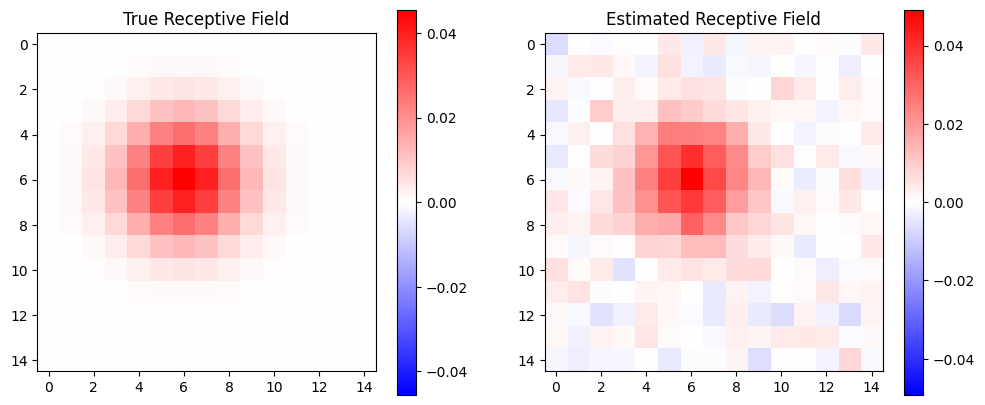

In [25]:
# insert your code here

# ------------------------------------
# Plot the ground truth and estimated
# `w` side by side. (0.5 pts)
# ------------------------------------

mosaic = [["True", "Estimated"]]
fig, ax = plt.subplot_mosaic(mosaic=mosaic, figsize=(12, 5))

# make sure to add a colorbar. 'bwr' is a reasonable choice for the cmap.

# true
vlim = np.max(np.abs(w))
img_true = ax["True"].imshow(w.reshape(15, 15), cmap="bwr", vmin=-vlim, vmax=vlim)
fig.colorbar(img_true, ax=ax["True"])
ax["True"].set_title("True Receptive Field")

# estiamted
vlim = np.max(np.abs(w_est))
img_est = ax["Estimated"].imshow(
    w_est.reshape(15, 15), cmap="bwr", vmin=-vlim, vmax=vlim
)
fig.colorbar(img_est, ax=ax["Estimated"])
ax["Estimated"].set_title("Estimated Receptive Field")

plt.show()

## Task 2: Apply to real neuron

Download the dataset for this task from Ilias (`nds_cl_5_data.mat`). It contains a stimulus matrix (`s`) in the same format you used before and the spike times. In addition, there is an array called `trigger` which contains the times at which the stimulus frames were swapped.

* Generate an array of spike counts at the same temporal resolution as the stimulus frames
* Fit the receptive field with time lags of 0 to 4 frames. Fit them one lag at a time (the ML fit is very sensitive to the number of parameters estimated and will not produce good results if you fit the full space-time receptive field for more than two time lags at once). 
* Plot the resulting filters

*Grading: 2 pts*


In [26]:
var = io.loadmat("nds_cl_5_data.mat")

# t contains the spike times of the neuron
t = var["DN_spiketimes"].flatten()

# trigger contains the times at which the stimulus flipped
trigger = var["DN_triggertimes"].flatten()

# contains the stimulus movie with black and white pixels
s = var["DN_stim"]
s = s.reshape((300, 1500))  # the shape of each frame is (20, 15)
s = s[:, 1 : len(trigger)]

Create vector of spike counts

In [27]:
# insert your code here

# ------------------------------------------
# Bin the spike counts at the same temporal
# resolution as the stimulus (0.5 pts)
# ------------------------------------------

c, _ = np.histogram(t, bins=trigger)

Fit receptive field for each frame separately

In [28]:
# insert your code here

# ------------------------------------------
# Fit the receptive field with time lags of
# 0 to 4 frames separately (1 pt)
#
# The final receptive field (`w_hat`) should
# be in the shape of (Dx * Dy, 5)
# ------------------------------------------

# specify the time lags
delta = [0, 1, 2, 3, 4]

Dx, Dy = 20, 15

# fit for each delay
w_hat = np.zeros((Dx * Dy, len(delta)))

w_init = np.random.uniform(-0.1, 0.1, size=(Dx, Dy)).flatten()

for i, lag in enumerate(delta):
    c_lag = c[lag:]
    s_lag = s[:, :-lag] if lag > 0 else s

    w_hat[:, i] = opt.minimize(
        fun=lambda x: negloglike_lnp(x, c_lag, s_lag),
        x0=w_init,
        jac=lambda x: deriv_negloglike_lnp(x, c_lag, s_lag),
    ).x
    w_hat[:, i] = w_hat[:, i] / np.sum(w_hat[:, i].flatten())

Plot the frames one by one

C:\Users\nekur\AppData\Local\Temp\ipykernel_10724\411084870.py:14: UserWarning: Adding colorbar to a different Figure <Figure size 1200x500 with 4 Axes> than <Figure size 1000x400 with 6 Axes> which fig.colorbar is called on.
  fig.colorbar(img_est, ax=ax[lag])


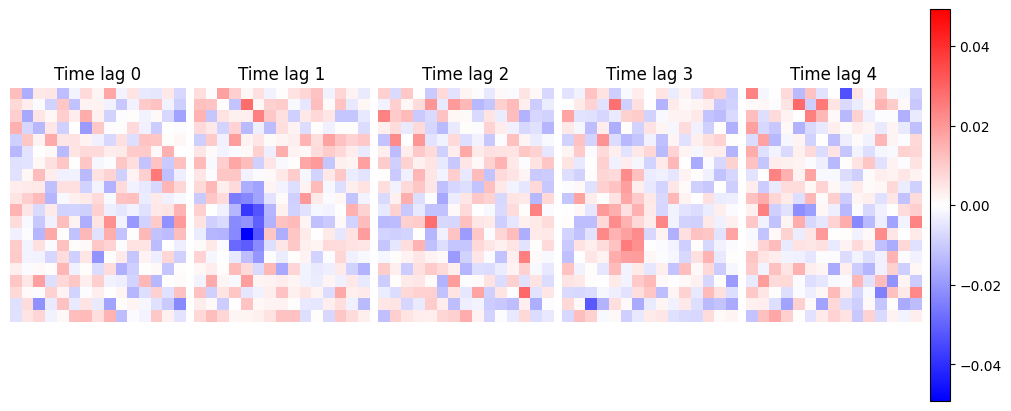

In [29]:
# insert your code here

# --------------------------------------------
# Plot all 5 frames of the fitted RFs (0.5 pt)
# --------------------------------------------

fig, ax = plt.subplot_mosaic(mosaic=[delta], figsize=(10, 4), constrained_layout=True)

vlim = np.max(np.abs(w_hat))
for i, lag in enumerate(delta):
    ax[lag].imshow(w_hat[:, i].reshape(Dx, Dy), cmap="bwr", vmin=-vlim, vmax=vlim)
    ax[lag].set_title(f"Time lag {lag}")
    ax[lag].axis("off")
fig.colorbar(img_est, ax=ax[lag])
plt.show()

## Task 3: Separate space/time components

The receptive field of the neuron can be decomposed into a spatial and a temporal component. Because of the way we computed them, both are independent and the resulting spatio-temporal component is thus called separable. As discussed in the lecture, you can use singular-value decomposition to separate these two: 

$$
W = u_1 s_1 v_1^T
$$

Here $u_1$ and $v_1$ are the singular vectors belonging to the 1st singular value $s_1$ and provide a long rank approximation of W, the array with all receptive fields. It is important that the mean is subtracted before computing the SVD.  

Plot the first temporal component and the first spatial component. You can use a Python implementation of SVD. The results can look a bit puzzling, because the sign of the components is arbitrary.

*Grading: 1 pts*

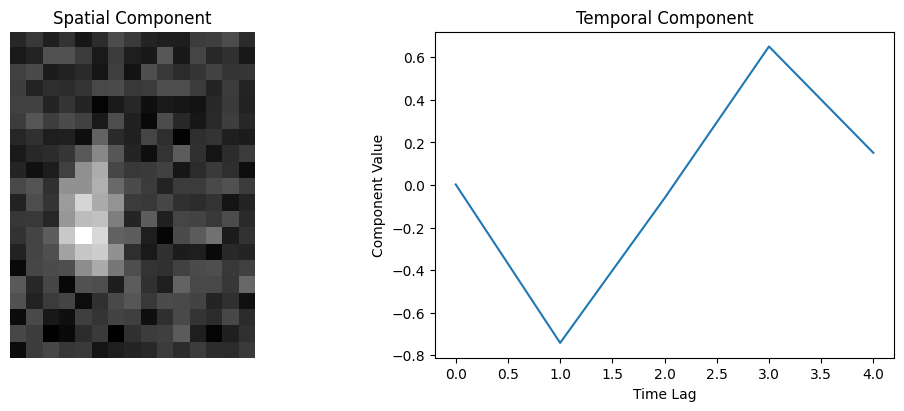

In [30]:
# insert your code here

# --------------------------------------------
# Apply SVD to the fitted receptive field,
# you can use either numpy or sklearn (0.5 pt)
# --------------------------------------------

# shape of w_hat: (300,5).
# subtract mean along axis=1 (time) since for every timelag the RF is estimated independently

w_hat_mean_subtracted = w_hat - np.mean(w_hat, axis=1, keepdims=True)

U, S, VT = np.linalg.svd(w_hat_mean_subtracted, full_matrices=False)

spatial_component = U[:, 0].reshape(Dx, Dy)
temporal_component = VT[0, :]


# -------------------------------------------------
# Plot the spatial and temporal components (0.5 pt)
# -------------------------------------------------

fig, ax = plt.subplot_mosaic(
    mosaic=[["Spatial", "Temporal"]], figsize=(10, 4), constrained_layout=True
)

# add plot
ax["Spatial"].imshow(spatial_component, cmap="gray")
ax["Spatial"].set_title("Spatial Component")
ax["Spatial"].axis("off")

ax["Temporal"].plot(temporal_component)
ax["Temporal"].set_title("Temporal Component")
ax["Temporal"].set_xlabel("Time Lag")
ax["Temporal"].set_ylabel("Component Value")

plt.show()

## Task 4: Regularized receptive field

As you can see, maximum likelihood estimation of linear receptive fields can be quite noisy, if little data is available. 

To improve on this, one can regularize the receptive field vector and a term to the cost function


$$
C(w) = L(w) + \alpha ||w||_p^2
$$

Here, the $p$ indicates which norm of $w$ is used: for $p=2$, this is shrinks all coefficient equally to zero; for $p=1$, it favors sparse solutions, a penality also known as lasso. Because the 1-norm is not smooth at zero, it is not as straightforward to implement "by hand". 

Use a toolbox with an implementation of the lasso-penalization and fit the receptive field. Possibly, you will have to try different values of the regularization parameter $\alpha$. Plot your estimates from above and the lasso-estimates. How do they differ? What happens when you increase or decrease $alpha$?

If you want to keep the Poisson noise model, you can use the implementation in [`pyglmnet`](https://pypi.python.org/pypi/pyglmnet). Otherwise, you can also resort to the linear model from `sklearn` which assumes Gaussian noise (which in my hands was much faster).

*Grading: 2 pts*


In [31]:
from sklearn import linear_model

# insert your code here

# ------------------------------------------
# Fit the receptive field with time lags of
# 0 to 4 frames separately (the same as before)
# with sklern or pyglmnet (1 pt)
# ------------------------------------------

delta = [0, 1, 2, 3, 4]

alpha = 0.03

# fit for each delay
w_hat = np.zeros((Dx * Dy, len(delta)))

w_init = np.random.uniform(-0.1, 0.1, size=(Dx, Dy)).flatten()


model = linear_model.Lasso(alpha=alpha)

for i, lag in enumerate(delta):
    c_lag = c[lag:]
    s_lag = s[:, :-lag] if lag > 0 else s
    w_hat[:, i] = model.fit(s_lag.T, c_lag).coef_

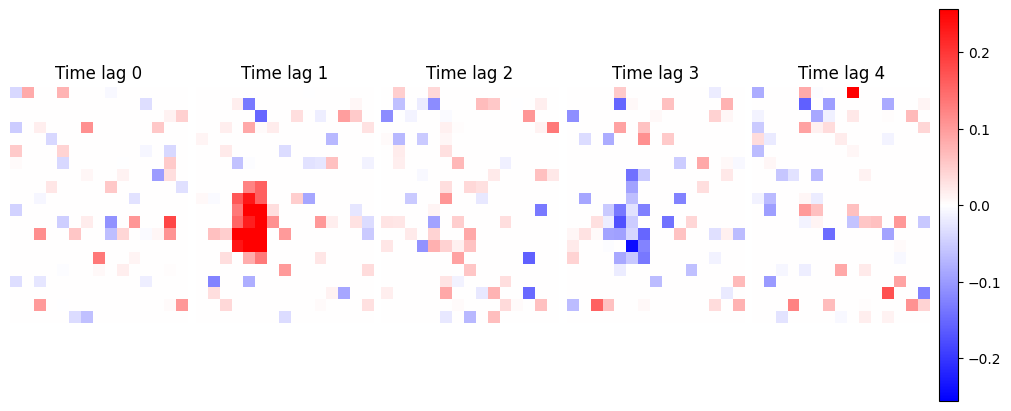

In [32]:
# ------------------------------------------
# plot the estimated receptive fields (1 pt)
# ------------------------------------------

fig, ax = plt.subplot_mosaic(mosaic=[delta], figsize=(10, 4), constrained_layout=True)
# add plot
for i, lag in enumerate(delta):
    img_est = ax[lag].imshow(
        w_hat[:, i].reshape(Dx, Dy), cmap="bwr", vmin=-vlim, vmax=vlim
    )
    ax[lag].axis("off")
    ax[lag].set_title(f"Time lag {lag}")
fig.colorbar(img_est, ax=ax[lag])
plt.show()